### Imports, Simulation Setup

In [226]:
import numpy as np 
import pandas as pd
from pulsee import simulation as sim, quantum_computing as qc, operators as op 
from pulsee.many_body import tensor_product

In [227]:
SIM_NAME = "uncorrelated_mixed_hyperfine_one_diagonal"

### Quantum System Setup
Spin-$\frac{1}{2}$ system with $\gamma/2\pi = 4.00$ MHz/T (see Candoli thesis §4.1) and $B_0 = 10$ T:

In [228]:
CORRELATED = False
MIXED = True
QUANTUM_NUMBER = 0.5
GAMMA_2PI = 4.00 
B_0 = 10

### Pulse
Set up single mode pulse of form 
$$\mathbf{B}_1(t) = 2 B_1 \cos(2\pi \nu + \delta)\cdot \hat{\mathbf{n}}(\theta, \phi)$$
where $\theta$ and $\phi$ are the polar and azimuthal angles respectively. $B_1$ in T, $\nu$ in MHz, $\delta$, $\phi$, and $\theta$ in radians. TODO: $\nu$ depends on $e^2 q Q $ and $\eta$? What is $\eta$? Why?

For simplest case apply $\pi/2$ pulse with $B_1 = B_0 / 100 $, $ \nu = (\gamma/2\pi) \cdot B_0 $, $\delta = \phi =0$, $\theta=\pi/2$.

In [229]:
B_1 = B_0 / 100
FREQ = GAMMA_2PI * B_0
PHASE = 0
POLAR_B = np.pi / 2 
AZIMUTHAL_B = 0 
PULSE_TIME = 1 / (4 * FREQ)
mode = pd.DataFrame([(FREQ, 2 * B_1, PHASE, POLAR_B, AZIMUTHAL_B)],
					columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

### Experiment Settings

In [230]:
ACQUISITION_TIME = 1000 # in microseconds
T2 = 100

### Hamiltonians
Here we add the desired Hamiltonian interaction terms. Add these to the following dictionary `args` with key as it appears in `nuclear_system_setup` function. The value should be the parameters of the associated Hamiltonian as it appears in `nuclear_system_setup`.

In [231]:
h_dict = {
	'h_tensor_inter': np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
}

### Density Matrix Setup 
If `CORRELATED`, apply a Hadamard gate then a CNOT gate. If `MIXED` sum four states' density matrices: 
$$\frac{1}{4}(\ket{00}\bra{00}+\ket{01}\bra{01} + \ket{10}\bra{10} + \ket{11}\bra{11})$$

If `CORRELATED` _and_ `MIXED` we sum the four density matrices of the Bell basis: 
$$
\frac{1}{4}(\ket{\Phi^+}\bra{\Phi^+} + \ket{\Phi^-}\bra{\Phi^-} 
				+ \ket{\Psi^+}\bra{\Psi^+} + \ket{\Psi^-}\bra{\Psi^-})
$$
where we construct the bell basis by applying a Hadamard and CNOT gate to each of 
the computational basis kets $\ket{00}$, $\ket{01}$, so on. 

In [232]:
initial_dm = None
initial_dm_matrix = 'canonical'

# Construct the tensor product of the Hadamard gate and identity operator
had_id = qc.n_gate(tensor_product(qc.hadamard, op.Operator(2)))

qs = qc.CompositeQubitSpace(2)
if CORRELATED and MIXED: 

	# Generate computational basis kets 
	comp_basis = qs.onb()

	# Generate Bell basis 
	corr_states = [qc.cnot(had_id(q)) for q in comp_basis]

	# Generate density matrix of mixed state with equal probability for each
	# Bell state. 
	initial_dm = 0 * op.DensityMatrix(2 ** 2)
	for i in corr_states: 
		initial_dm += (1/4) * i.density_matrix

	initial_dm_matrix = initial_dm.matrix
elif MIXED: 
	# Generate computational basis kets 
	comp_basis = qs.onb() 

	# Generate density matrix of mixed state with equal probability for each 
	# basis state
	initial_dm = 0 * op.DensityMatrix(2 ** 2)
	for i in comp_basis: 
		initial_dm += (1/4) * i.density_matrix
	initial_dm_matrix = initial_dm.matrix 
elif CORRELATED: 
	# Use state ket |00⟩
	q = qs.basis_ket_from_indices([0, 0])

	# Create entanglement 
	corr_state = had_id(q)
	initial_dm = corr_state.density_matrix
	initial_dm_matrix = initial_dm.matrix

initial_dm_matrix

array([[0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j]])

### Simulation

In [233]:
args = h_dict.copy()
spin_par = {'quantum number': QUANTUM_NUMBER, 'gamma/2pi': GAMMA_2PI} 
args['spin_par'] = [spin_par, spin_par]
args['initial_state'] = initial_dm_matrix

spin, h_unperturbed, initial_dm = sim.nuclear_system_setup(**args)

evolved_dm = sim.evolve(spin, h_unperturbed, initial_dm, 
						mode=mode, pulse_time=PULSE_TIME)

t, fid = sim.FID_signal(spin, h_unperturbed, evolved_dm, 
						acquisition_time=ACQUISITION_TIME, T2=T2)
						
f, ft = sim.fourier_transform_signal(t, fid, -1, 1)

Write simulation parameters and save plots to a directory. 

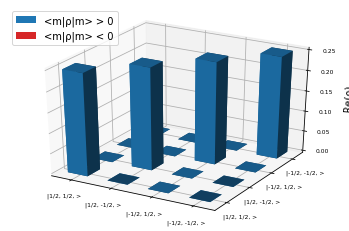

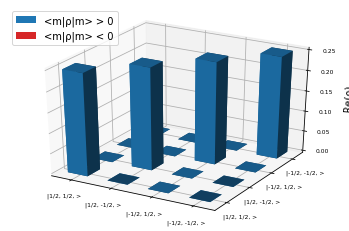

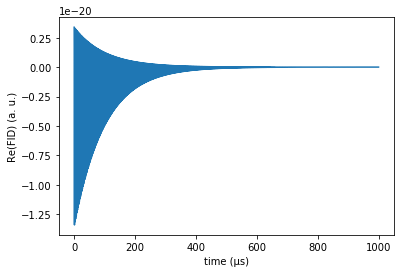

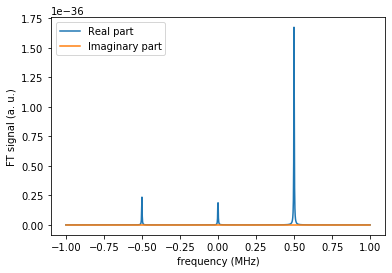

In [234]:
import os 
import json 
import shutil

sim_dir = None 
if SIM_NAME is not None: 
	sim_dir = f'./simulation_results/{SIM_NAME}/'
else:
	i = 1
	while os.path.isdir(f'./simulation_results/sim_{i:04d}'):
		i += 1

	sim_dir = f'./simulation_results/sim_{i:04d}/'

if os.path.isdir(sim_dir):
	shutil.rmtree(sim_dir)

os.mkdir(sim_dir)

# numpy ndarray can't be json serialized
if 'h_tensor_inter' in h_dict.keys(): 
	h_dict['h_tensor_inter'] = h_dict['h_tensor_inter'].tolist()

params = {
	'correlated_state': CORRELATED, 
	'mixed': MIXED, 
	'quantum_number': QUANTUM_NUMBER, 
	'gamma_2pi': GAMMA_2PI, 
	'pulse_params': {
		'amplitude': 2 * B_1, 
		'frequency': FREQ, 
		'phase': PHASE, 
		'theta_p': POLAR_B, 
		'phi_p': AZIMUTHAL_B, 
		'pulse_time': PULSE_TIME
	},
	'acquisition_time': ACQUISITION_TIME, 
	't2': T2,
	'hamiltonian_args': h_dict
}

params_file = open(os.path.join(sim_dir, 'params.json'), 'w')
json.dump(params, params_file, indent=4, separators=(',', ': '))
params_file.close()
 
np.savetxt(os.path.join(sim_dir, 'initial_dm.csv'),
		   initial_dm.matrix)

np.savetxt(os.path.join(sim_dir, 'evolved_dm.csv'),
		   evolved_dm.matrix)

np.savetxt(os.path.join(sim_dir, 't_fid_data.csv'), 
		   np.transpose(np.array([t, fid])),
		   delimiter=',', 
		   header='t,fid')
		   
np.savetxt(os.path.join(sim_dir, 'f_ft_data.csv'),
		   np.transpose(np.array([f, ft])),
		   delimiter=',',
		   header='f,ft')

sim.plot_real_part_density_matrix(initial_dm, 
								  save=True, 
								  destination=sim_dir,
								  name="InitialRealPartDensityMatrix",
								  many_spin_indexing=[2, 2])
sim.plot_real_part_density_matrix(evolved_dm,
								  save=True, 
								  destination=sim_dir,
								  name="EvolvedRealPartDensityMatrix", 
								  many_spin_indexing=[2, 2])
sim.plot_real_part_FID_signal(t, fid, save=True, destination=sim_dir)
_ = sim.plot_fourier_transform(f, np.abs(ft) ** 2, save=True, destination=sim_dir)
